
## Gearbox Health Monitoring

The database contains the signals of acceleration of gearbox operating under three different gear conditions:

1) Healthy;

2) One chipped tooth;

3) Three worn teeth .

Dataset from:

@article{zamanianexperimental,

  title={Experimental Dataset for Gear Fault Diagnosis},
  
  author={Zamanian, Amir Hosein}
}

# Hybrid CNN+SVM classification model:


In [ ]:
#libraries:

import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling1D, Flatten, Input,Conv1D, UpSampling2D, Reshape
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from scipy.io import loadmat

#

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### Loading .mat dataset:

In [ ]:
from scipy.io import loadmat

class1=loadmat('Gearbox_no_fault_full_load_01_December_2009_10kHz_pos1.mat')
class2=loadmat('Gearbox_a_chipped_tooth_full_load_03_December_2009_10kHz_pos1.mat')
class3=loadmat('Gearbox_three_worn_teeth_full_load_13_December_2009_10kHz_pos1.mat')



### Signal Visualization (Time and Frequency):

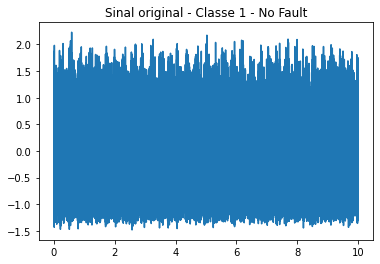

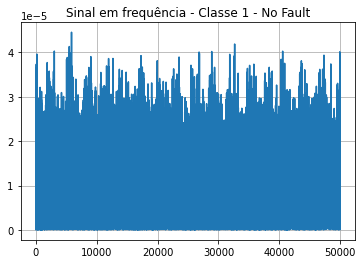

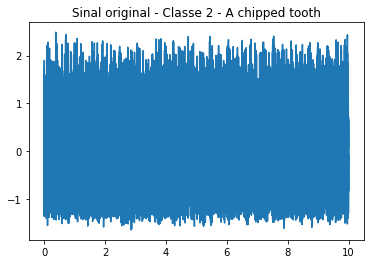

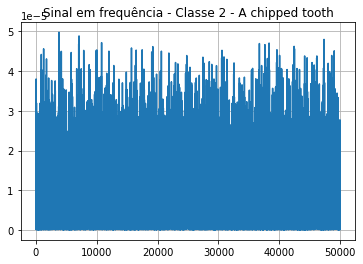

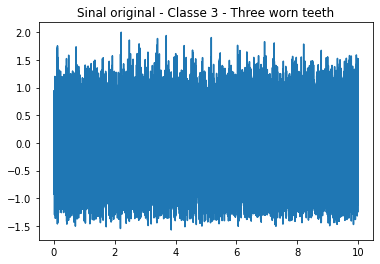

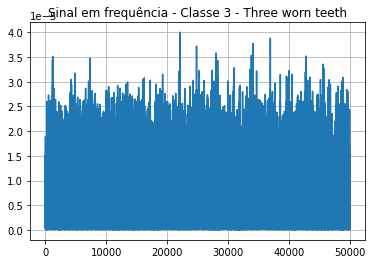

In [ ]:
from scipy.fft import fft
#Taxa de amostragem:
Fs=10e3
T=1/Fs
# Number of sample points:
N=Fs*10
t = np.linspace(0.0,N*T,int(N))
xf = np.linspace(0.0,10/(2.0*T),int(N//2))
yf1 = fft(class1['acc'])
yf2 = fft(class2['acc'])
yf3 = fft(class3['acc'])
plt.figure(1)
plt.title("Sinal original - Classe 1 - No Fault")
plt.plot(t,class1['acc'])
plt.figure(2)
plt.title("Sinal em frequência - Classe 1 - No Fault")
plt.plot(xf, 2.0/N * np.abs(yf1[0:int(N//2)]))
plt.grid()
plt.figure(3)
plt.title("Sinal original - Classe 2 - A chipped tooth")
plt.plot(t,class2['acc'])
plt.figure(4)
plt.title("Sinal em frequência - Classe 2 - A chipped tooth")
plt.plot(xf, 2.0/N * np.abs(yf2[0:int(N//2)]))
plt.grid()
plt.figure(5)
plt.title("Sinal original - Classe 3 - Three worn teeth")
plt.plot(t,class3['acc'])
plt.figure(6)
plt.title("Sinal em frequência - Classe 3 - Three worn teeth")
plt.plot(xf, 2.0/N * np.abs(yf3[0:int(N//2)]))
plt.grid()


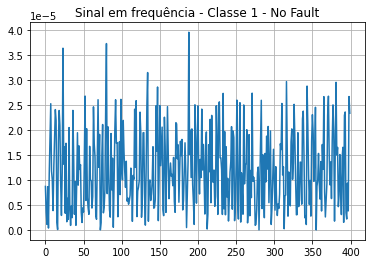

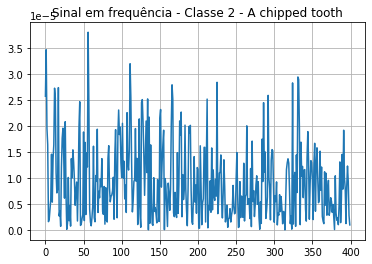

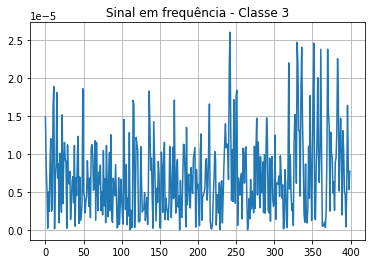

In [ ]:
plt.figure(2)
plt.title("Sinal em frequência - Classe 1 - No Fault")
yp=2.0/N * np.abs(yf1[0:int(N//2)])
plt.plot(xf[0:400], 2.0/N * np.abs(yf1[0:400]))
plt.grid()
plt.figure(4)
plt.title("Sinal em frequência - Classe 2 - A chipped tooth")
plt.plot(xf[0:400], 2.0/N * np.abs(yf2[0:400]))
plt.grid()
plt.figure(6)
plt.title("Sinal em frequência - Classe 3")
plt.plot(xf[0:400], 2.0/N * np.abs(yf3[0:400]))
plt.grid()

### The data were sampled at a rate of 10kHz for 10s for each class. Just as the authors did, I divided each 10s signal into 80 (30 for training set and 50 for test set), each with 1250 samples.

In [ ]:
np.random.seed(0)
myord=np.random.permutation(80)
y1=class1['acc'].reshape(80,1250, 1)
y2=class2['acc'].reshape(80,1250, 1)
y3=class3['acc'].reshape(80,1250, 1)


In [ ]:
y_train=np.r_[y1[myord][0:30],y2[myord][0:30],y3[myord][0:30]]
S_train=np.r_[np.zeros(30),np.ones(30),2*np.ones(30)]
y_test=np.r_[y1[myord][-50:],y2[myord][-50:],y3[myord][-50:]]
S_test=np.r_[np.zeros(50),np.ones(50),2*np.ones(50)]


### CNN+Fully:

In [ ]:
input_signal = Input(shape=(y_train.shape[1], 1))
x = Conv1D(40, kernel_size=(350), strides=2,activation='relu')(input_signal)
x = MaxPooling1D(pool_size=(8))(x)
x = Conv1D(8, kernel_size=(15),activation='relu')(x)
x = MaxPooling1D(pool_size=(2))(x)
x = Conv1D(4, kernel_size=(15),activation='relu')(x)
encoded = Flatten()(x)
decoded = Dense(28, activation='sigmoid')(encoded)
decoded = Dense(3, activation='softmax')(decoded)
CNN_Fully = Model(input_signal,decoded)
CNN_Fully.summary()



Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1250, 1)]         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 451, 40)           14040     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 56, 40)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 42, 8)             4808      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 21, 8)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 7, 4)              484       
_________________________________________________________________
flatten_7 (Flatten)          (None, 28)              

In [ ]:
CNN_Fully.compile(loss="sparse_categorical_crossentropy",
                   optimizer='Adam',
                    metrics=['accuracy'])
history=CNN_Fully.fit(y_train, S_train,batch_size = 2, epochs=35)
model_json = CNN_Fully.to_json()
json_file = open("model_CNN_Fully.json", "w")
json_file.write(model_json)
json_file.close()
CNN_Fully.save_weights("model_CNN_Fully.h5")
print("Model saved to disk")
os.getcwd()

Epoch 1/35
45/45 [==============================] - 0s 8ms/step - loss: 1.0656 - accuracy: 0.4778
Epoch 2/35
45/45 [==============================] - 0s 8ms/step - loss: 0.8370 - accuracy: 0.7000
Epoch 3/35
45/45 [==============================] - 0s 8ms/step - loss: 0.5859 - accuracy: 0.9111
Epoch 4/35
45/45 [==============================] - 0s 8ms/step - loss: 0.4239 - accuracy: 0.9889
Epoch 5/35
45/45 [==============================] - 0s 8ms/step - loss: 0.3041 - accuracy: 1.0000
Epoch 6/35
45/45 [==============================] - 0s 8ms/step - loss: 0.2195 - accuracy: 1.0000
Epoch 7/35
45/45 [==============================] - 0s 8ms/step - loss: 0.1511 - accuracy: 1.0000
Epoch 8/35
45/45 [==============================] - 0s 7ms/step - loss: 0.1126 - accuracy: 1.0000
Epoch 9/35
45/45 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 1.0000
Epoch 10/35
45/45 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 1.0000
Epoch 11/35
45/45 [

'/content'

### Performance CNN+Fully:

In [ ]:
print("Performance para dados de teste:")
CNN_Fully.evaluate(y_test, S_test)
print("Performance para dados de treino:")
CNN_Fully.evaluate(y_train, S_train)
print("Matriz de Confusão (Dados de teste):")
y_pred=CNN_Fully.predict(y_test)
#result = np.where(y_pred == maxInColumns)
cm=metrics.confusion_matrix(y_true=S_test, y_pred=np.argmax(y_pred, axis=1))
print(cm)


Performance para dados de teste:
5/5 [==============================] - 0s 11ms/step - loss: 0.0920 - accuracy: 0.9667
Performance para dados de treino:
3/3 [==============================] - 0s 9ms/step - loss: 0.0076 - accuracy: 1.0000
Matriz de Confusão (Dados de teste):
[[50  0  0]
 [ 0 48  2]
 [ 0  3 47]]


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Matriz de Confusão',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')

Confusion matrix, without normalization
[[50  0  0]
 [ 0 48  2]
 [ 0  3 47]]


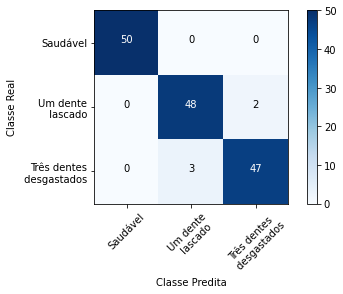

In [ ]:
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=False,title='')

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.96 0.04]
 [0.   0.06 0.94]]


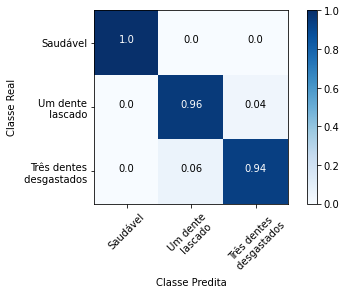

In [ ]:
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=True,title='')

### Generating the weights in manifold:

In [ ]:
CNN = Model(input_signal,encoded)
y_proj_train = CNN.predict(y_train)
y_proj_test = CNN.predict(y_test)
print("Pontos no manifold (Treino):") #Train compressed data.
print(np.shape(y_proj_train))
print("Pontos no manifold (Teste):") #Test compressed data.
print(np.shape(y_proj_test))

Pontos no manifold (Treino):
(90, 28)
Pontos no manifold (Teste):
(150, 28)


In [ ]:
CNN_json = CNN.to_json()
json_file = open("CNN.json", "w")
json_file.write(CNN_json)
json_file.close()
CNN.save_weights("CNN.h5")
print("CNN saved to disk")

CNN saved to disk


### SVM:

In [ ]:
# linear model

model_linear = SVC(decision_function_shape='ovo',kernel='linear')
model_linear.fit(y_proj_train, S_train)

# predict
y_pred = model_linear.predict(y_proj_test)

### Performance CNN+SVM linear:

accuracy: 1.0 

Confusion matrix, without normalization
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


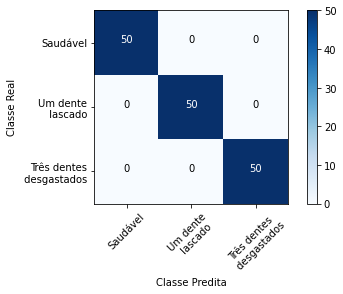

In [ ]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=S_test, y_pred=y_pred), "\n")

# cm
cm=metrics.confusion_matrix(y_true=S_test, y_pred=y_pred)
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=False, title='')


Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


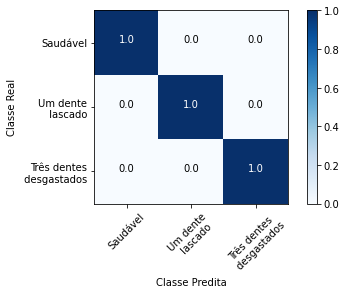

In [ ]:
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=True, title='')

### SVM Kernel RBF:

In [ ]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(decision_function_shape='ovo',kernel='rbf')

# fit
non_linear_model.fit(y_proj_train, S_train)

# predict
y_pred = non_linear_model.predict(y_proj_test)

###Performance CNN+SVM Kernel RBF:

accuracy 0.9933333333333333 

Confusion matrix, without normalization
[[50  0  0]
 [ 0 49  1]
 [ 0  0 50]]


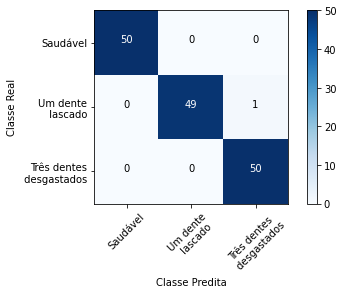

In [ ]:
# model with optimal hyperparameters

# model
model = SVC(decision_function_shape='ovo',C=1, gamma=0.00044 , kernel="rbf")

model.fit(y_proj_train, S_train)
y_pred = model.predict(y_proj_test)

# metrics
print("accuracy", metrics.accuracy_score(S_test, y_pred), "\n")
cm=metrics.confusion_matrix(S_test, y_pred)
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=False, title='')

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.98 0.02]
 [0.   0.   1.  ]]


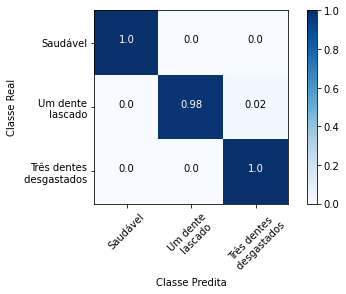

In [ ]:
cm_plot_labels = ['Saudável','Um dente\n lascado','Três dentes\n desgastados']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=True, title='')

### T-SNE

In [ ]:
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
#%% t-SNE

MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

def fit(X):
    n_samples = X.shape[0]
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()  
    obj_func = _kl_divergence
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
    X_embedded = params.reshape(n_samples, n_components)
    
    return X_embedded

def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad
def _gradient_descent(obj_func, p0, args, it=0, n_iter=2000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p



In [ ]:
X_embedded = fit(y_proj_test)

[t-SNE] Iteration 1: error = 1.5476846, gradient norm = 0.0000111
[t-SNE] Iteration 2: error = 1.5476846, gradient norm = 0.0000360
[t-SNE] Iteration 3: error = 1.5476836, gradient norm = 0.0002003
[t-SNE] Iteration 4: error = 1.5476427, gradient norm = 0.0013524
[t-SNE] Iteration 5: error = 1.5452004, gradient norm = 0.0105810
[t-SNE] Iteration 6: error = 1.4008352, gradient norm = 0.0582907
[t-SNE] Iteration 7: error = 0.6332989, gradient norm = 0.0310634
[t-SNE] Iteration 8: error = 0.4267648, gradient norm = 0.0236641
[t-SNE] Iteration 9: error = 0.3578854, gradient norm = 0.0152915
[t-SNE] Iteration 10: error = 0.3505086, gradient norm = 0.0142382
[t-SNE] Iteration 11: error = 0.3423210, gradient norm = 0.0125061
[t-SNE] Iteration 12: error = 0.3366672, gradient norm = 0.0129122
[t-SNE] Iteration 13: error = 0.3246587, gradient norm = 0.0119464
[t-SNE] Iteration 14: error = 0.3143838, gradient norm = 0.0114449
[t-SNE] Iteration 15: error = 0.3043331, gradient norm = 0.0107703
[t-S

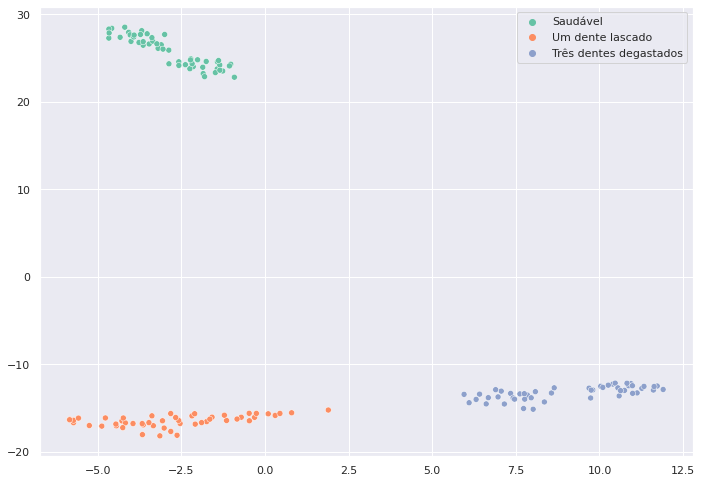

In [ ]:
palette = sns.color_palette("Set2",3)
S=S_test.tolist()
for i in range(50):
  S[i]="Saudável"
for i in range(50):
  S[i+100]="Três dentes degastados"
for i in range(50):
  S[i+50]="Um dente lascado"
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=S, legend='full', palette=palette)